!sudo apt-get install curl git  

!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [1]:
from konlpy.tag import Mecab
from packages import utils


from glob import  glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf

/opt/conda/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Step 1. 데이터 로드

In [2]:
import numpy as np; 
import seaborn as sns; 

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

In [3]:
train_data_path = glob("./data/train/*")
test_data_path = glob("./data/test/*")
dev_data_path = glob("./data/dev/*")

def data_load(data_path):
    result = []
    for setences in data_path:
        with open(setences) as f:
            result += [f.readlines()]
    en, ko = result        
    data = pd.DataFrame({"en":en, "ko":ko})
    return data

train = data_load(train_data_path)
test = data_load(test_data_path)
dev = data_load(dev_data_path)

cp_train = train.copy()
cp_test = test.copy()
cp_dev = dev.copy()

## Step 2. 데이터 정제

### 중복 데이터 제거

In [4]:
cp_train = cp_train.drop_duplicates("en", keep = "first")
cp_train = cp_train.drop_duplicates("ko", keep = "first")

cp_test = cp_test.drop_duplicates("en", keep = "first")
cp_test = cp_test.drop_duplicates("ko", keep = "first")

cp_dev = cp_dev.drop_duplicates("en", keep = "first")
cp_dev = cp_dev.drop_duplicates("ko", keep = "first")

### 공동 텍스트 전처리

In [5]:
cp_train["ko"] = cp_train["ko"].apply(lambda x : utils.text_preprocessing(x))
cp_train["en"] = cp_train["en"].apply(lambda x : utils.text_preprocessing(x))

cp_test["ko"] = cp_test["ko"].apply(lambda x : utils.text_preprocessing(x))
cp_test["en"] = cp_test["en"].apply(lambda x : utils.text_preprocessing(x))

cp_dev["ko"] = cp_dev["ko"].apply(lambda x : utils.text_preprocessing(x))
cp_dev["en"] = cp_dev["en"].apply(lambda x : utils.text_preprocessing(x))

### 결측 데이터 제거

In [6]:
cp_train = utils.remove_nan(cp_train)
cp_test = utils.remove_nan(cp_test)
cp_dev = utils.remove_nan(cp_dev)

### 영어, 한국어 텍스트 전처리

In [7]:
mecab = Mecab()
def ko_pre(sentence):
    return mecab.morphs(sentence)


def en_pre(sentence):
    return ["<bos>"] + sentence.lower().split(" ") + ["<eos>"]

In [8]:
cp_train["pre_ko"] = cp_train["ko"].apply(lambda x: ko_pre(x))
cp_train["pre_en"] = cp_train["en"].apply(lambda x: en_pre(x))

cp_train["pre_ko_len"] = cp_train["pre_ko"].apply(lambda x: len(x))
cp_train["pre_en_len"] = cp_train["pre_en"].apply(lambda x: len(x))
cp_train = cp_train[cp_train["pre_ko_len"] <= 40]
cp_train = cp_train[cp_train["pre_en_len"] <= 40]

In [9]:
cp_test["pre_ko"] = cp_test["ko"].apply(lambda x: ko_pre(x))
cp_test["pre_en"] = cp_test["en"].apply(lambda x: en_pre(x))

cp_test["pre_ko_len"] = cp_test["pre_ko"].apply(lambda x: len(x))
cp_test["pre_en_len"] = cp_test["pre_en"].apply(lambda x: len(x))
cp_test = cp_test[cp_test["pre_ko_len"] <= 40]
cp_test = cp_test[cp_test["pre_en_len"] <= 40]

In [10]:
cp_dev["pre_ko"] = cp_dev["ko"].apply(lambda x: ko_pre(x))
cp_dev["pre_en"] = cp_dev["en"].apply(lambda x: en_pre(x))

cp_dev["pre_ko_len"] = cp_dev["pre_ko"].apply(lambda x: len(x))
cp_dev["pre_en_len"] = cp_dev["pre_en"].apply(lambda x: len(x))
cp_dev = cp_dev[cp_dev["pre_ko_len"] <= 40]
cp_dev = cp_dev[cp_dev["pre_en_len"] <= 40]

In [11]:
print(f"훈련 데이터셋 : {cp_train.shape}")
print(f"검증 데이터셋 : {cp_dev.shape}")
print(f"테스트 데이터셋 : {cp_test.shape}")

훈련 데이터셋 : (61881, 6)
검증 데이터셋 : (806, 6)
테스트 데이터셋 : (1546, 6)


## Step 3. 데이터 토큰

In [12]:
vocab_size = 10000 
ko_bin_dict = utils.bin_dict(cp_train["pre_ko"])
ko_word_index, ko_index_word = utils.word_index(ko_bin_dict, vocab_size)
x_train = utils.tokenization(cp_train["pre_ko"], ko_word_index)

en_bin_dict = utils.bin_dict(cp_train["pre_en"])
en_word_index, en_index_word = utils.word_index(en_bin_dict, vocab_size)
y_train = utils.tokenization(cp_train["pre_en"], en_word_index)

100%|██████████| 61881/61881 [00:00<00:00, 113756.64it/s]


In [13]:
x_dev = utils.tokenization(cp_dev["pre_ko"], ko_word_index)
y_dev = utils.tokenization(cp_dev["pre_en"], en_word_index)

100%|██████████| 806/806 [00:00<00:00, 144143.99it/s]


In [14]:
x_test = utils.tokenization(cp_test["pre_ko"], ko_word_index)
y_test = utils.tokenization(cp_test["pre_en"], en_word_index)

100%|██████████| 1546/1546 [00:00<00:00, 151437.31it/s]


In [15]:
np.max(x_train), np.min(x_train)

(9999, 0)

## Step 4. 모델 설계

In [16]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [17]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [18]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [19]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

## Step 5. 훈련하기

In [35]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok['<sos>']] * bsz, 1)
        print(dec_src)
        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [34]:
y_train[:,0].shape

(61881,)

In [30]:
src = x_train[:5]
bsz = src.shape[0]
enc_out = encoder(src)
h_dec = enc_out[:, -1]

dec_src = tf.expand_dims([en_word_index['<sos>']] * bsz, 1)


pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)


In [31]:
pred

<tf.Tensor: shape=(5, 10000), dtype=float32, numpy=
array([[-0.00163111, -0.00153533, -0.0022845 , ..., -0.00296807,
         0.00198207, -0.00052143],
       [-0.00199406, -0.00148948, -0.00209272, ..., -0.00278297,
         0.00180787, -0.00042814],
       [-0.00133712, -0.00172316, -0.00232098, ..., -0.00306246,
         0.00206417, -0.00054173],
       [-0.00173508, -0.0015147 , -0.0022149 , ..., -0.00296246,
         0.00184622, -0.00046001],
       [-0.00219218, -0.00128892, -0.00212783, ..., -0.00260037,
         0.00169254, -0.00041501]], dtype=float32)>

In [36]:
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok['<sos>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss

In [37]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 1
BATCH_SIZE = 64
SRC_VOCAB_SIZE = 10000
TGT_VOCAB_SIZE = 10000

units = 256
embedding_dim = 100

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)


for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, x_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(x_train[idx:idx+BATCH_SIZE],
                                y_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                ko_word_index)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0, x_dev.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(x_dev[idx:idx+BATCH_SIZE],
                                    y_dev[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    ko_word_index)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

  0%|          | 0/967 [00:00<?, ?it/s]

Tensor("ExpandDims:0", shape=(64, 1), dtype=int32)


  0%|          | 0/967 [00:07<?, ?it/s]


KeyboardInterrupt: 

100%|██████████| 1/1 [00:00<00:00, 10672.53it/s]


Input: 나는 배가 고프다
Predicted translation: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


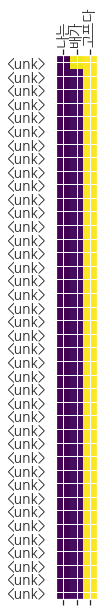

In [69]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((y_train.shape[-1], x_train.shape[-1]))
    
    
    inputs = utils.text_preprocessing(sentence)
    inputs = [ko_pre(inputs)]
    inputs = utils.tokenization(inputs, ko_word_index, max_length = x_train.shape[-1])
    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([ko_word_index['<sos>']], 0)

    for t in range(y_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += ko_index_word[predicted_id] + ' '

        if ko_index_word[predicted_id] == '<eos>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


translate("나는 배가 고프다", encoder, decoder)